# Quality Assesment Notebook

This notebook displays basic info and plots. 
It should run on your local computer, provided that you've 
download the \*-exp.fits and \*-exp.h5 files, but you can run
at jupyter.nersc.gov, once you've setup your 
environment (see below).

***WARNING:*** If you open a .h5 file (fit outputs) ***make sure you use the 'r' option***. Otherwise, you might overwrite the file and lose its contents. @TODO: add a protection againts this attack, for now ***please be careful.***

***Reminder***: your modifications will modify your local copy of the notebook, if you want to share those modifications, please do a PR. You might lose them if the notebook is modified and you update picca to the latest master. If you are unsure what this means, make a copy of the file (e.g. to your home) and work with it.

***How to setup the jupyter environment at NERSC***:
(you need to do this only once)

First, create a conda environment dedicated to picca plots:
    
    conda config --add channels intel conda-forge defaults
    conda create -n picca_plots ipykernel fitsio h5py scipy matplotlib healpy
    source activate picca_plots
    cd $HOME/igmhub/picca
    python setup.py install
    python -m ipykernel install --user --name picca_plots --display-name picca_plots
    source deactivate

Point your browser to jupyter.nersc.gov. After you login, you should see a `picca_plots` kernel. Double click on it. Navigate the left menu to open $HOME/igmhub/picca/tutorials/QA_plots.ipynb 

***notes:***

 * The setup.py install step will install picca only in your picca_plots environment and will not conflict with your previous installation, independently of whether you used PYTHONPATH or setup.py install (we need the setup.py install setp in the env because PYTHONPATH is not visible from the jupyter.nersc.gov).


In [433]:
import os
import glob
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import scipy as sp
import scipy.stats
from scipy.interpolate import interp1d

from picca import wedgize

%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
plt.rc('text',usetex=True)

***INFO:*** you can safely ignore the h5py error message (if any) in the cell above

Set up the different path to the data and to the mocks

In [614]:
### Get mocks
mock = {}
mock['mock_ver'] = 'v4.0.0'
mock['quick_ver'] = 'eboss-0.0'
mock['mock_base'] = '/project/projectdirs/desi/mocks/lya_forest/london/'+mock['mock_ver']+'/'
mock['mock_quick'] = mock['mock_base']+'/'+mock['quick_ver']+'/'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [615]:
### Get mock products
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0/'
mock['picca_delta'] = mock['picca']+'/deltas/'
mock['picca_delta_attributes'] = mock['picca']+'/iter.fits.gz'
mock['picca_delta_log'] = mock['picca']+'/input.log'
mock['picca_cf1d'] = mock['picca']+'/cf1d_z_0_10.fits.gz'

In [619]:
### Get data products
data = {}
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v4_4__THINGID_DR7.fits'
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/'
data['picca_delta'] = data['picca']+'/Delta_LYA/Delta/'
data['picca_delta_attributes'] = data['picca']+'/Delta_LYA/Log/delta_attributes.fits.gz'
data['picca_cf1d'] = data['picca']+'/Correlations_LYA/cf1d.fits.gz'
data['picca_cf'] = data['picca']+'/Correlations_LYA/forFits_cf_forest1_LYA_line1_LYA.fits.gz'
data['picca_xcf'] = data['picca']+'/Correlations_LYA/forFits_xcf_forest1_LYA_line1_LYA_obj1_QSO.fits.gz'
data['picca_fit_cf'] = data['picca']+'/Correlations_LYA/Fit/LYA_LYA/result.h5'
data['picca_fit_xcf'] = data['picca']+'/Correlations_LYA/Fit/LYA_QSO/result.h5'
data['picca_fit_cfxcf'] = data['picca']+'/Correlations_LYA/Fit/LYA_LYA__LYA_QSO/result.h5'

# __Catalogs__

In [588]:
# Catalogs
cat_path = {'master':mock['mock_base']+'master.fits',
            'zcat':mock['mock_quick']+'/zcat.fits',
            'desiDRQ':mock['mock_quick']+'/zcat_desi_drq.fits',
            'random':mock['mock_base']+'/master_randoms.fits.gz',
            'Data(DR14)':data['QSO_catalog'],
            }
redshift_key = {'master':'Z_QSO_RSD', 'zcat':'Z', 'desiDRQ':'Z','random':'Z','Data(DR14)':'Z'}

### Redshift distribution of the different catalogs

The following cell calculates the redshift distribution of the 
catalogs

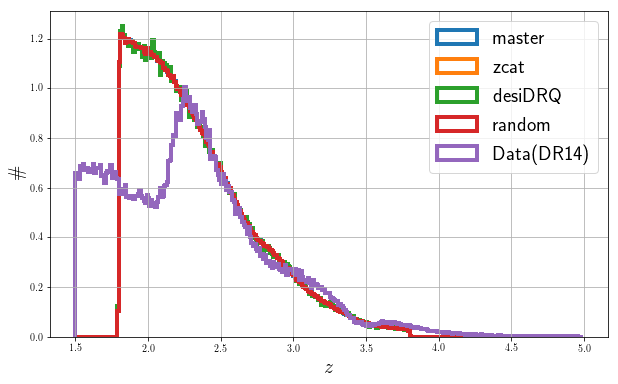

In [589]:
bins = sp.arange(1.5,5.,0.01)
for name,path in cat_path.items():
    h = fitsio.FITS(os.path.expandvars(path))
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

#### The following function allows to have a 2d histogram

In [439]:
def Get_2DTProfile(ar1, ar2, ar3, nbBinsX, nbBinsY,we=None):

    if we is None:
        we = sp.ones_like(ar1)
    d = sp.array(list(zip(ar1,ar2,ar3)))
    number, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1))
    weight, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we  )
    mean,   axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*ar3)
    err,    axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*(ar3**2.))

    w = number>1
    mean[w]   /= weight[w]
    err[w]    = sp.sqrt((err[w]/weight[w]-mean[w]**2.)/number[w])

    mean   = mean[:,:,0]
    err    = err[:,:,0]
    number = number[:,:,0]

    return mean, err, number

### Density of objects on the sky

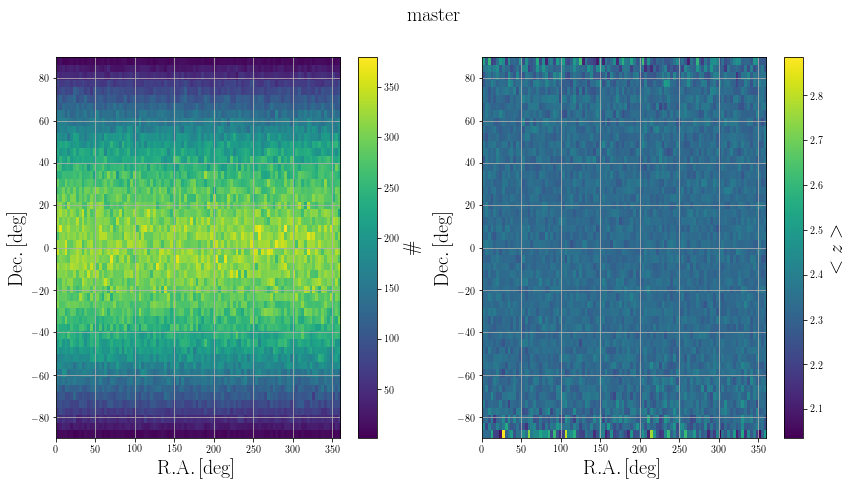

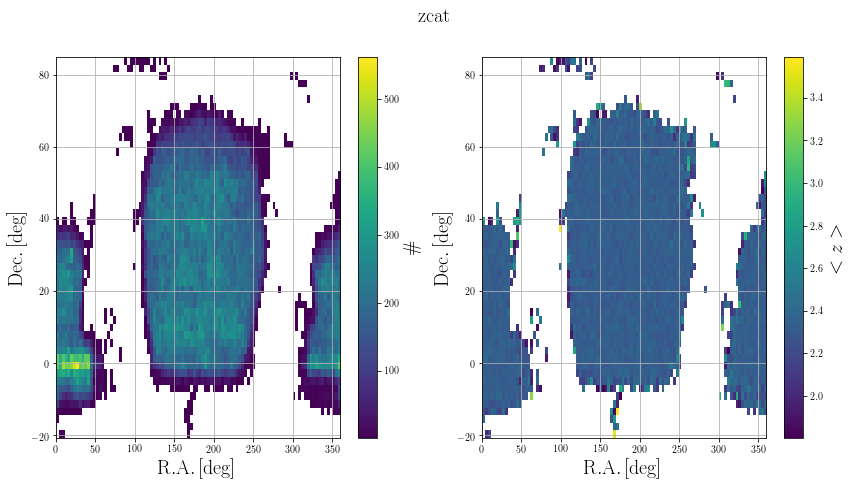

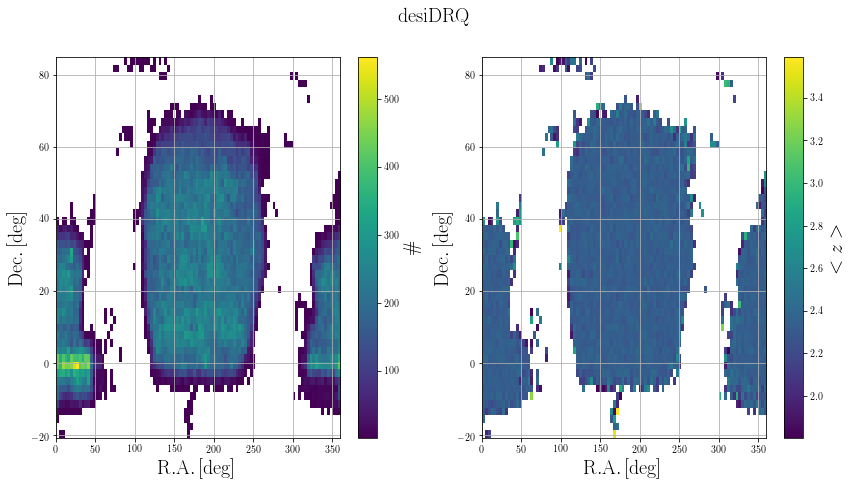

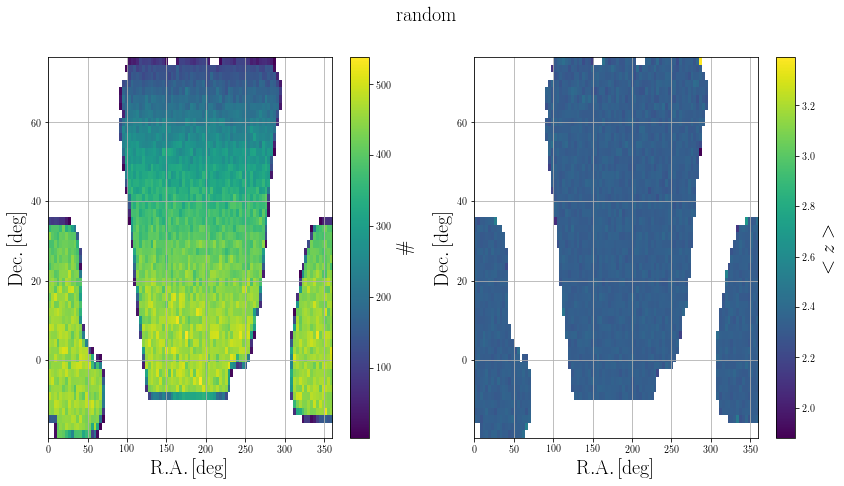

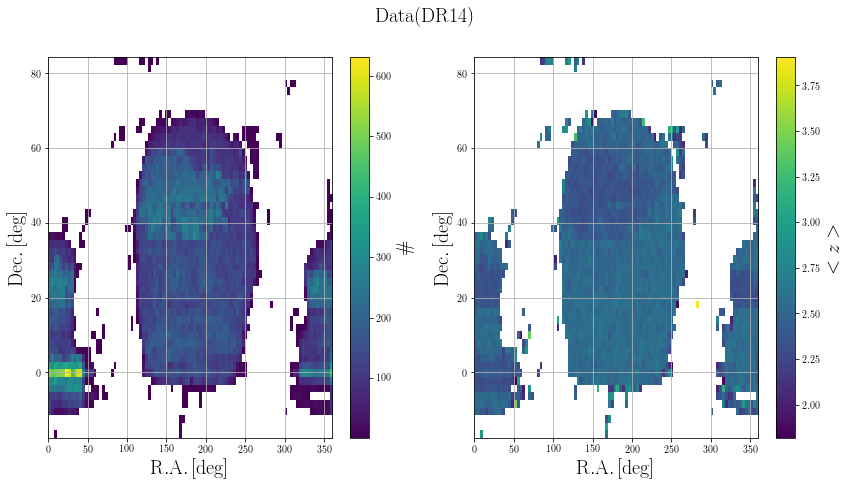

In [440]:
sp.random.seed(42)
nbQSO = 1000000
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]
    h.close()
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]
    w = z>1.8
    ra = ra[w]
    dec = dec[w]
    z = z[w]
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    
    mean_nb, err_nb, number_nb = Get_2DTProfile(ra, dec, sp.ones(ra.size), 100, 50)
    number_nb = sp.transpose(number_nb)
    number_nb[number_nb==0.] = sp.nan
    plot1 = ax1.imshow(number_nb, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar1 = plt.colorbar(plot1, ax=ax1)
    cbar1.set_label(r'$\#$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()
    
    mean_z, err_z, number_z = Get_2DTProfile(ra, dec, z, 100, 50)
    mean_z = sp.transpose(mean_z)
    number_z = sp.transpose(number_z)
    mean_z[number_z==0.] = sp.nan
    plot2 = ax2.imshow(mean_z, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar2 = plt.colorbar(plot2,ax=ax2)
    cbar2.set_label(r'$<z>$',size=20)
    cbar2.update_ticks()
    ax2.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax2.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax2.grid()
    
    plt.subplots_adjust(wspace=0.2)

### Magnitude distribution

In [441]:
toPlot = {}
toPlot['Mocks'] = {}
toPlot['Mocks']['NAME'] = {0:'g: decam', 1:'r: decam', 2:'z: decam', 3:'wise1', 4:'wise2'}
h = fitsio.FITS(cat_path['zcat'])
flx = sp.zeros( (h['ZCATALOG']['FLUX_G'][:].size,5) )
flx[:,0] = h['ZCATALOG']['FLUX_G'][:]
flx[:,1] = h['ZCATALOG']['FLUX_R'][:]
flx[:,2] = h['ZCATALOG']['FLUX_Z'][:]
flx[:,3] = h['ZCATALOG']['FLUX_W1'][:]
flx[:,4] = h['ZCATALOG']['FLUX_W2'][:]
toPlot['Mocks']['FLUX'] = flx.copy()
toPlot['Mocks']['Z'] = h['ZCATALOG']['Z'][:]
toPlot['Mocks']['RA'] = h['ZCATALOG']['RA'][:]
toPlot['Mocks']['DEC'] = h['ZCATALOG']['DEC'][:]
h.close()

In [442]:
toPlot['Data'] = {}
toPlot['Data']['NAME'] = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z'}
h = fitsio.FITS(data['QSO_catalog'])
toPlot['Data']['FLUX'] = h[1]['PSFFLUX'][:]
toPlot['Data']['Z'] = h[1]['Z'][:]
toPlot['Data']['RA'] = h[1]['RA'][:]
toPlot['Data']['DEC'] = h[1]['DEC'][:]
h.close()

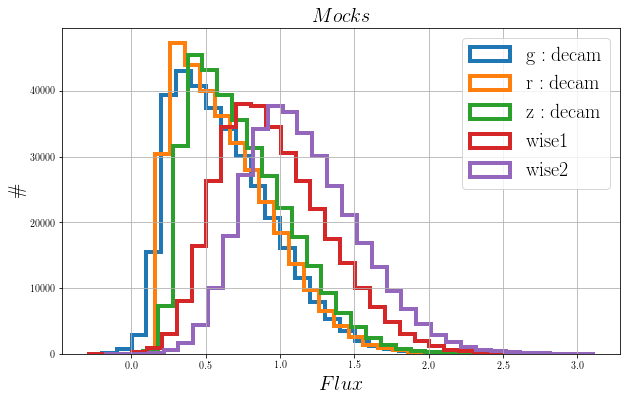

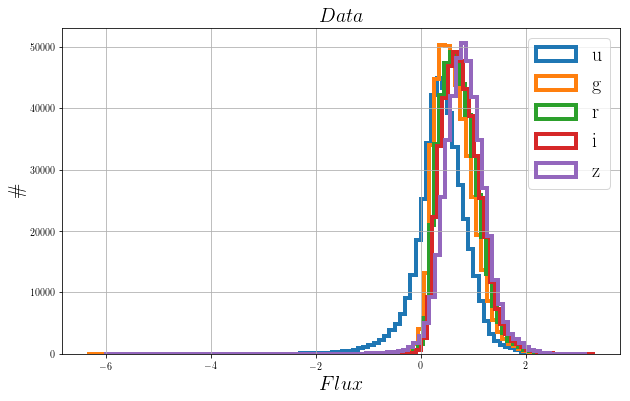

In [443]:
for name,vals in toPlot.items():
    flx = vals['FLUX']
    for i in range(5):
        w = flx[:,i]>0.
        bins = sp.arange(sp.log10(flx[:,i][w].min()), sp.log10(flx[:,i][w].max()), 0.1)
        plt.hist(sp.log10(flx[:,i][w]),bins=bins,linewidth=4,histtype='step',label=r'$\mathrm{'+vals['NAME'][i]+'}$')
    plt.xlabel(r'$Flux$')
    plt.ylabel(r'$\#$')
    plt.title(r'$'+name+'$',fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

#### The following function allows to get the profile

In [444]:
def Get_TProfile(ar1, ar2, nbBin1, we2=None):

    if we2 is None:
        we2 = sp.ones_like(ar1)
    number, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1))
    weight, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2)
    mean,   axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*ar2)
    err,    axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*(ar2**2.))

    ### find the axis X
    axisX = sp.array([ axisX[i]+(axisX[i+1]-axisX[i])/2. for i in range(0,axisX.size-1) ])
    
    ### Get only not empty bins
    bool_number = (number[:,0]>1)
    
    axisX  = axisX[bool_number]
    number = number[:,0][bool_number]
    weight = weight[:,0][bool_number]
    mean   = mean[:,0][bool_number]
    err    = err[:,0][bool_number]

    mean  = mean/weight
    err   = sp.sqrt((err/weight-mean**2.)/number)

    return axisX, mean, err, number

### Magnitude vs. redshift

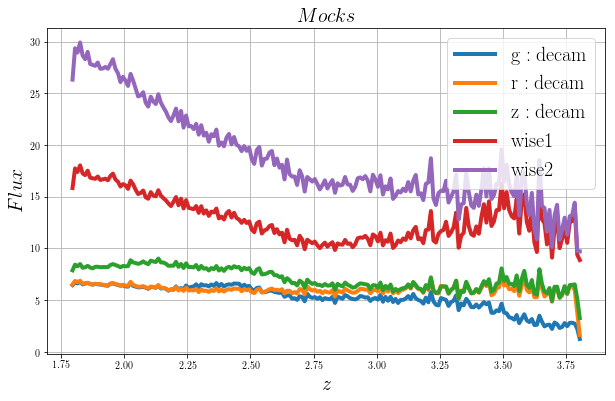

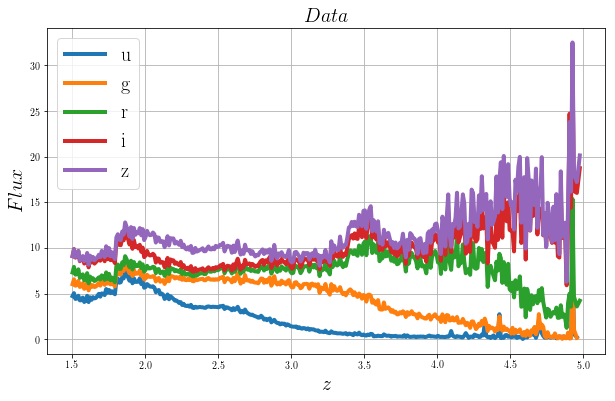

In [445]:
bins = sp.arange(1.5, 5., 0.01)
for name,vals in toPlot.items():
    flx = vals['FLUX']
    for i in range(5):
        w = flx[:,i]>0.
        axisX, mean, err, number = Get_TProfile(vals['Z'][w],flx[:,i][w], bins)
        plt.plot(axisX, mean,linewidth=4,label=r'$\mathrm{'+vals['NAME'][i]+'}$')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$Flux$')
    plt.title(r'$'+name+'$',fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

### Magnitude on the sky

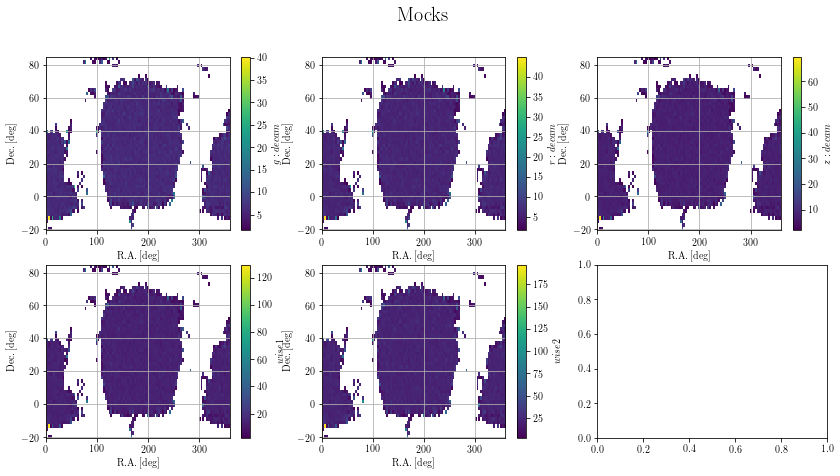

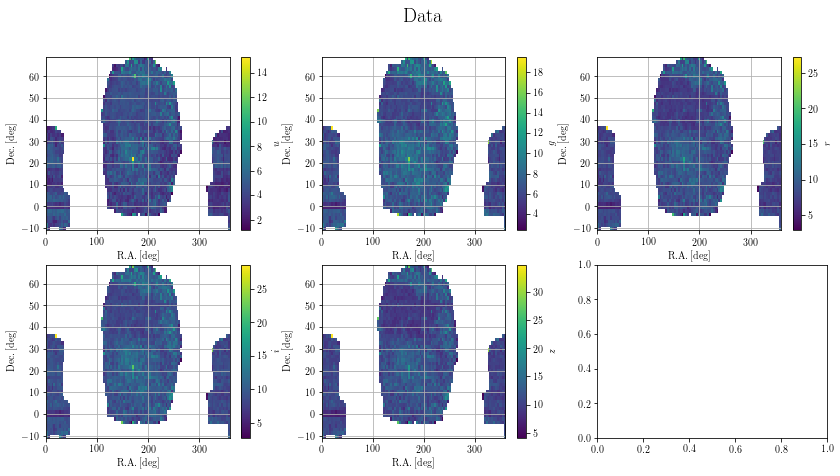

In [446]:
for name,vals in toPlot.items():
    flx = vals['FLUX']
    ra = vals['RA']
    dec = vals['DEC']
    
    f, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    plot = []
    cbar = []
    
    for i in range(5):
        w = flx[:,i]>0.
        
        extent = [ra[w].min(), ra[w].max(), dec[w].min(), dec[w].max()]
        mean, err, number = Get_2DTProfile(ra[w], dec[w], flx[:,i][w], 100, 50)
        mean = sp.transpose(mean)
        number = sp.transpose(number)
        mean[number==0.] = sp.nan
        plot += [axs[i//3,i%3].imshow(mean, interpolation='nearest', origin='lower',extent=extent, aspect='auto')]
        cbar += [plt.colorbar(plot[-1],ax=axs[i//3,i%3])]
        cbar[-1].set_label(r'$'+vals['NAME'][i]+'$',size=10)
        cbar[-1].update_ticks()
        axs[i//3,i%3].set_xlabel(r'$\mathrm{R.A. \, [deg]}$',fontsize=10)
        axs[i//3,i%3].set_ylabel(r'$\mathrm{Dec. \, [deg]}$',fontsize=10)
        axs[i//3,i%3].grid()
    plt.show()

# __Lya Transmission__

In [447]:
### Get all transmission files
fs = sp.sort(glob.glob(mock['mock_base']+'/*/*/transmission-*-*.fits'))
fs = fs[:10]
lLYA = 1215.67
lminforest = 1215.67

In [448]:
### Along the observed wavelength 
lObs_min = 3000.
lObs_max = 8000.
lObs_stack = sp.arange(lObs_min,lObs_max,1.)
z_stack = lObs_stack/lLYA-1.
T_stack = sp.zeros(lObs_stack.size)
TVar_stack = sp.zeros(lObs_stack.size)
n_stack = sp.zeros(lObs_stack.size)
T_stack_delta = sp.zeros(lObs_stack.size)
TVar_stack_delta = sp.zeros(lObs_stack.size)
n_stack_delta = sp.zeros(lObs_stack.size)

In [449]:
### Along the rest-frame wavelength
lRF_min = 100.
lRF_max = 4000.
lRF_stack = sp.arange(lRF_min,lRF_max,1.)
T_lRF_stack = sp.zeros(lRF_stack.size)
TVar_lRF_stack = sp.zeros(lRF_stack.size)
n_lRF_stack = sp.zeros(lRF_stack.size)
T_lRF_stack_delta = sp.zeros(lRF_stack.size)
TVar_lRF_stack_delta = sp.zeros(lRF_stack.size)
n_lRF_stack_delta = sp.zeros(lRF_stack.size)

In [450]:
### Get the transmission
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = lRF<lminforest
    lObs = lObs[w]
    lRF = lRF[w]
    trans = trans[w]

    bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*lObs_stack.size ).astype(int)
    T_stack += sp.bincount(bins,weights=trans,minlength=lObs_stack.size)
    TVar_stack += sp.bincount(bins,weights=trans**2,minlength=lObs_stack.size)
    n_stack += sp.bincount(bins,minlength=lObs_stack.size)

    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    T_lRF_stack += sp.bincount(bins,weights=trans,minlength=lRF_stack.size)
    TVar_lRF_stack += sp.bincount(bins,weights=trans**2,minlength=lRF_stack.size)
    n_lRF_stack += sp.bincount(bins,minlength=lRF_stack.size)

In [451]:
### Normalize the vectors (obseved wavelength)
w = n_stack>0.
T_stack[w] /= n_stack[w]
TVar_stack[w] /= n_stack[w]
TVar_stack -= T_stack**2
trans_vs_lObs = interp1d(lObs_stack[w],T_stack[w],fill_value='extrapolate',kind='nearest')

### Normalize the vectors (rest-frame wavelength)
w = n_lRF_stack>0.
T_lRF_stack[w] /= n_lRF_stack[w]
TVar_lRF_stack[w] /= n_lRF_stack[w]
TVar_lRF_stack -= T_lRF_stack**2

In [452]:
### Get the delta
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    h.close()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = lRF<lminforest
    lObs = lObs[w]
    lRF = lRF[w]
    trans = trans[w]/trans_vs_lObs(lObs)-1.

    bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*lObs_stack.size ).astype(int)
    T_stack_delta += sp.bincount(bins,weights=trans,minlength=lObs_stack.size)
    TVar_stack_delta += sp.bincount(bins,weights=trans**2,minlength=lObs_stack.size)
    n_stack_delta += sp.bincount(bins,minlength=lObs_stack.size)

    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    T_lRF_stack_delta += sp.bincount(bins,weights=trans,minlength=lRF_stack.size)
    TVar_lRF_stack_delta += sp.bincount(bins,weights=trans**2,minlength=lRF_stack.size)
    n_lRF_stack_delta += sp.bincount(bins,minlength=lRF_stack.size)

In [453]:
### Normalize the vectors (obseved wavelength)
w = n_stack_delta>0.
T_stack_delta[w] /= n_stack_delta[w]
TVar_stack_delta[w] /= n_stack_delta[w]
TVar_stack_delta -= T_stack_delta**2

### Normalize the vectors (rest-frame wavelength)
w = n_lRF_stack_delta>0.
T_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta -= T_lRF_stack_delta**2

In [454]:
### from measurement on data
### The input mean flux that we were trying to match corresponds
### to F(z=2.25)=0.8, and a slope in optical depth of (1+z)^3.2.
A = -sp.log(0.8)/(1.+2.25)**3.2
B = 3.2
print(' optical depth = ', A, B)
T_measure = sp.exp(-A*(1.+z_stack)**B)
DVar_measure = 0.0018*(1.+z_stack)**(2.*2.9-2.)
TVar_measure = DVar_measure*T_measure**2

 optical depth =  0.005135202633916249 3.2


### Transmission vs. redshift

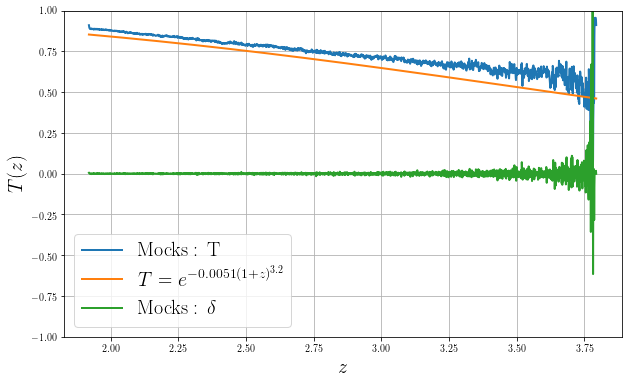

In [455]:
w = n_stack>0.
plt.plot(z_stack[w],T_stack[w],linewidth=2,label=r'$\mathrm{Mocks: \, T}$')
plt.plot(z_stack[w],T_measure[w],linewidth=2,label=r'$T = e^{-0.0051(1+z)^{3.2}}$')
w = n_stack_delta>0.
plt.plot(z_stack[w],T_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks: \, \delta}$')
plt.xlabel(r'$z$')
plt.ylabel(r'$T(z)$')
plt.legend()
plt.grid()
_=plt.ylim(-1,1)

### Variance of the transmission vs. of redshift

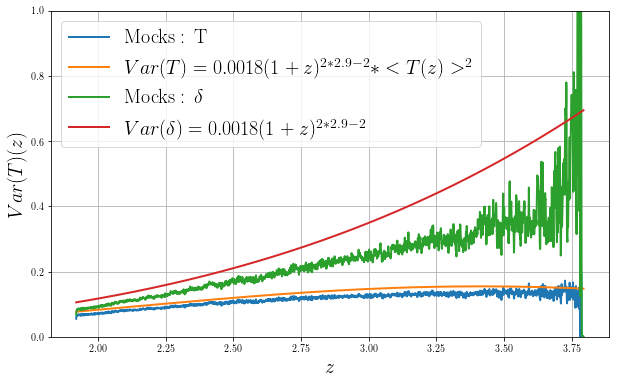

In [456]:
w = n_stack>0.
plt.plot(z_stack[w],TVar_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
plt.plot(z_stack[w],TVar_measure[w],linewidth=2,label=r'$Var(T) = 0.0018 (1+z)^{2*2.9-2} * <T(z)>^{2}$')
w = n_stack_delta>0.
plt.plot(z_stack[w],TVar_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.plot(z_stack[w],DVar_measure[w],linewidth=2,label=r'$Var(\delta) = 0.0018 (1+z)^{2*2.9-2}$')
plt.xlabel(r'$z$')
plt.ylabel(r'$Var(T)(z)$')
plt.legend()
plt.grid()
_=plt.ylim(0,1)

### Transmission vs. rest-frame wavelength

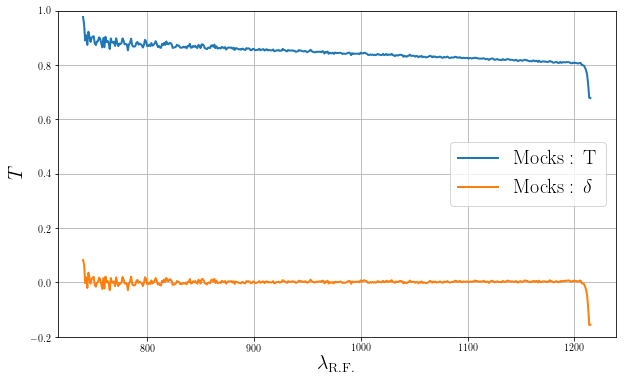

In [457]:
w = n_lRF_stack>0.
plt.plot(lRF_stack[w],T_lRF_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],T_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$')
plt.ylabel(r'$T$')
plt.legend()
plt.ylim(-0.2,1)
plt.grid()

### Variance of the transmission vs. rest-frame wavelength

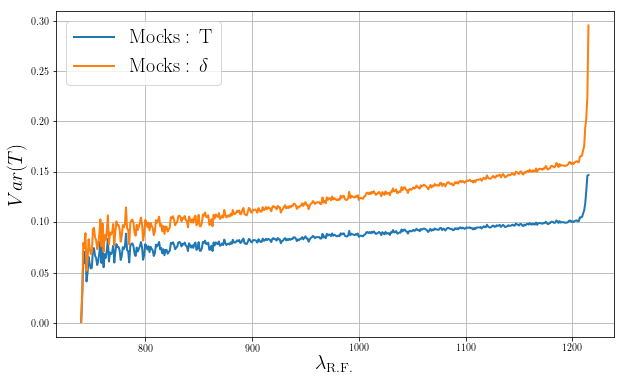

In [458]:
w = n_lRF_stack>0.
plt.plot(lRF_stack[w],TVar_lRF_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],TVar_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$')
plt.ylabel(r'$Var(T)$')
plt.legend()
plt.grid()

# __Example spectrum__

In [658]:
### Get the different path to spectrum
trans_path = mock['mock_base']+'/3/333/transmission-16-333.fits'
spec_path = mock['mock_quick']+'/spectra-16/3/333/spectra-16-333.fits'

In [659]:
### Get delta nside
h = fitsio.FITS(mock['picca_delta_attributes'])
nside = h[1].read_header()['NSIDE']
h.close()

In [661]:
### Get the spectrum
h = fitsio.FITS(spec_path)
try:
    hra = h['FIBERMAP']['TARGET_RA'][:]
    hde = h['FIBERMAP']['TARGET_DEC'][:]
except ValueError:
    hra = h['FIBERMAP']['RA_TARGET'][:]
    hde = h['FIBERMAP']['DEC_TARGET'][:]
tid = h['FIBERMAP']['TARGETID'][:]
b_ll = sp.log10(h['B_WAVELENGTH'].read())
b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
b_fl = h['B_FLUX'].read()
r_ll = sp.log10(h['R_WAVELENGTH'].read())
r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
r_fl = h['R_FLUX'].read()
try:
    z_ll = sp.log10(h['Z_WAVELENGTH'].read())
    z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
    z_fl = h['Z_FLUX'].read()
except:
    print('WARNING: No z spectrograph')
    pass

In [662]:
### Get Transmission
h = fitsio.FITS(trans_path)
z = h['METADATA']['Z'][:]
ra = h['METADATA']['RA'][:]
de = h['METADATA']['DEC'][:]
lObs = h['WAVELENGTH'].read()
trans = h['TRANSMISSION'].read()
h.close()
lRF = lObs/(1.+z[:,None])
lObs = lObs*sp.ones(z.size)[:,None]

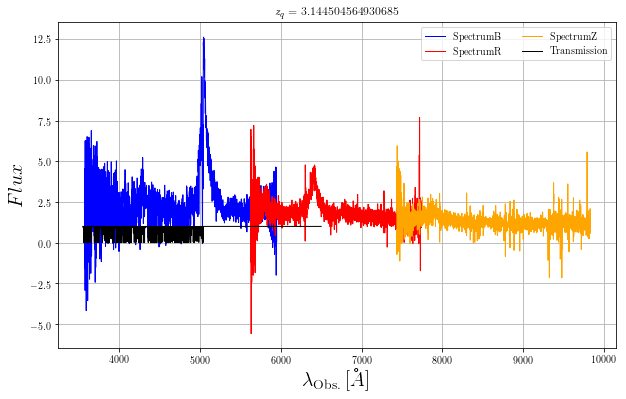

In [667]:
### Plot the first n spectra
for idx in range(1):
    ra_idx = hra[idx]
    de_idx = hde[idx]
    z_idx = z[ra==hra[idx]][0]
    tid_idx = tid[idx]

    delt_pix = healpy.ang2pix(nside, sp.pi/2.-de_idx*sp.pi/180., ra_idx*sp.pi/180.)
    #delta = fitsio.FITS(mock['picca_delta']+'/delta-'+str(delt_pix)+'.fits.gz')
    #deltaa = delta[str(tid_idx)]

    nidx = sp.arange(ra.size)[ra==ra_idx][0]
    plt.plot(10**b_ll,b_fl[idx,:],color='blue',label=r'$\mathrm{Spectrum B}$',linewidth=1)
    plt.plot(10**r_ll,r_fl[idx,:],color='red',label=r'$\mathrm{Spectrum R}$',linewidth=1)
    try:
        plt.plot(10**z_ll,z_fl[idx,:],color='orange',label=r'$\mathrm{Spectrum Z}$',linewidth=1)
    except:
        pass
    plt.plot(lObs[nidx,:],trans[nidx,:],color='black',label=r'$\mathrm{Transmission}$',linewidth=1)
    #plt.plot(10**deltaa['LOGLAM'][:],deltaa['DELTA'][:],color='green',label=r'$\mathrm{Delta}$',linewidth=1)
    #plt.plot(10**deltaa['LOGLAM'][:],deltaa['CONT'][:],color='violet',label=r'$\mathrm{Continuum}$',linewidth=1)
    
    plt.title(r'$z_{q} = '+str(z[ra==hra[idx]][0])+'$')
    plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
    plt.ylabel(r'$Flux$')
    plt.legend(ncol=2,fontsize=10)
    #plt.xlim([3000.,5000.])
    #plt.ylim([0.,10.])
    plt.grid()

# __Distribution of flux, ivar and SNR__

In [468]:
toPlot = {}

In [486]:
### Mocks
toPlot['Mocks'] = {'WAVE':None, 'FLUX':None, 'IVAR':None}
fs = sp.sort(glob.glob(mock['mock_quick']+'/spectra-16/*/*/spectra-16-*.fits'))
fs = fs[:10]
for f in fs:
    h = fitsio.FITS(f)
    nbQSO = h['B_IVAR'].read().shape[0]
    
    b_ll = h['B_WAVELENGTH'].read()
    b_ll = b_ll*sp.ones(nbQSO)[:,None]
    b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
    b_fl = h['B_FLUX'].read()
    
    r_ll = h['R_WAVELENGTH'].read()
    r_ll = r_ll*sp.ones(nbQSO)[:,None]
    r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
    r_fl = h['R_FLUX'].read()
    
    try:
        z_ll = h['Z_WAVELENGTH'].read()
        z_ll = z_ll*sp.ones(nbQSO)[:,None]
        z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
        z_fl = h['Z_FLUX'].read()
    except:
        pass

    wave = sp.append(b_ll,r_ll)
    flux = sp.append(b_fl,r_fl)
    ivar = sp.append(b_iv,r_iv)
    try:
        wave = sp.append(wave,z_ll)
        flux = sp.append(flux,z_fl)
        ivar = sp.append(ivar,z_iv)
    except:
        pass

    w = ivar>0.
        
    if toPlot['Mocks']['WAVE'] is None:
        toPlot['Mocks']['WAVE'] = wave[w].copy().flatten()
        toPlot['Mocks']['FLUX'] = flux[w].copy().flatten()
        toPlot['Mocks']['IVAR'] = ivar[w].copy().flatten()
    else:
        toPlot['Mocks']['WAVE'] = sp.append(toPlot['Mocks']['WAVE'],wave[w])
        toPlot['Mocks']['FLUX'] = sp.append(toPlot['Mocks']['FLUX'],flux[w])
        toPlot['Mocks']['IVAR'] = sp.append(toPlot['Mocks']['IVAR'],ivar[w])

In [487]:
### Data
toPlot['Data'] = {'WAVE':None, 'FLUX':None, 'IVAR':None}
h = fitsio.FITS(data['QSO_catalog'])
w = (h[1]['Z'][:]>1.8) & (sp.arange(h[1]['Z'][:].size)<1000) & (h[1]['PLATE'][:]>=3520)
lst = zip(h[1]['PLATE'][:][w], h[1]['MJD'][:][w], h[1]['FIBERID'][:][w])
h.close()

for p,m,f in lst:
    path = data['Spectra']+str(p).zfill(4)+'/spPlate-' +str(p).zfill(4)+'-'+str(m)+'.fits'
    h = fitsio.FITS(path)
    flux = h[0].read()
    ivar = h[1].read()*(h[1].read()>0)*(h[2].read()==0)
    end = h[2].read()
    hdr = h[0].read_header()
    h.close()
    wave = hdr['CRVAL1'] + hdr['CD1_1']*sp.arange(hdr['NAXIS1'])
    if hdr['DC-FLAG']:
        wave = 10**wave

    w = ivar[f-1,:]>0.
    if toPlot['Data']['WAVE'] is None:
        toPlot['Data']['WAVE'] = wave[w].copy()
        toPlot['Data']['FLUX'] = flux[f-1,w].copy()
        toPlot['Data']['IVAR'] = ivar[f-1,w].copy()
    else:
        toPlot['Data']['WAVE'] = sp.append(toPlot['Data']['WAVE'],wave[w])
        toPlot['Data']['FLUX'] = sp.append(toPlot['Data']['FLUX'],flux[f-1,w])
        toPlot['Data']['IVAR'] = sp.append(toPlot['Data']['IVAR'],ivar[f-1,w])

### Distribution of wavelength

Mocks 3569.39990234375 9833.400390625
Data 3554.6758199906994 10401.596438661036


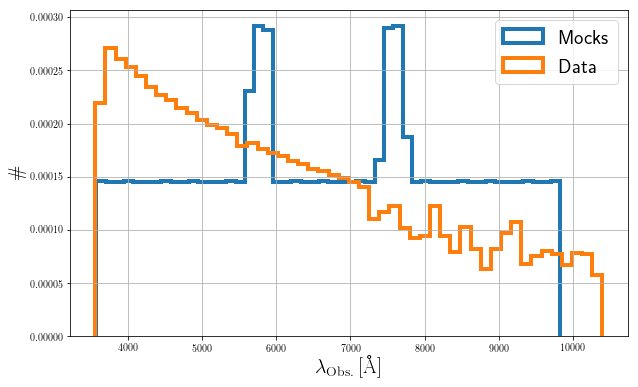

In [488]:
for name,vals in toPlot.items():
    print(name, vals['WAVE'].min(), vals['WAVE'].max() )
    plt.hist(vals['WAVE'],bins=50,histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$\#$')
plt.legend()
plt.grid()
plt.show()

### Distribution of flux

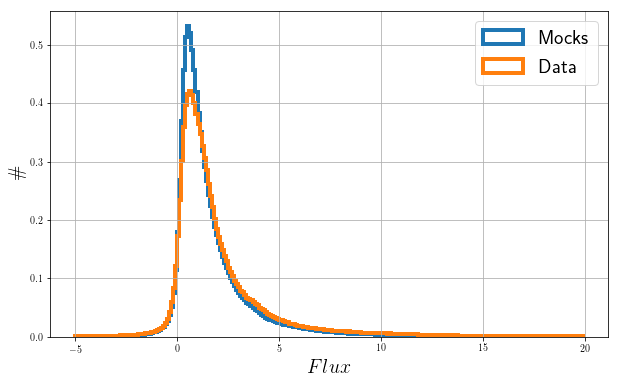

In [489]:
for name,vals in toPlot.items():
    plt.hist(vals['FLUX'],bins=sp.arange(-5.,20.,0.1),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$Flux$')
plt.ylabel(r'$\#$')
plt.legend()
plt.grid()
plt.show()

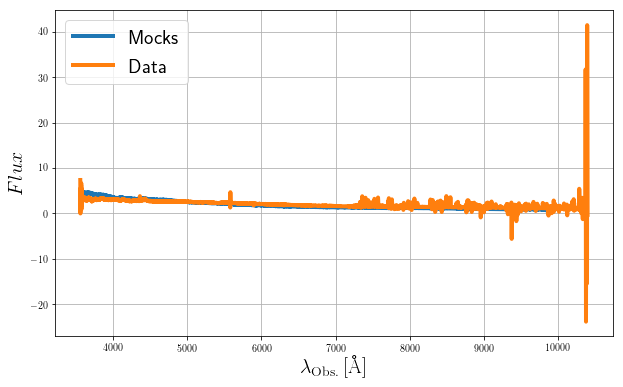

In [490]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in toPlot.items():

    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=vals['FLUX'],minlength=x.size)
    var = sp.bincount(bins,weights=vals['FLUX']**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$Flux$')
plt.legend()
plt.grid()
plt.show()

### Distribution of ivar

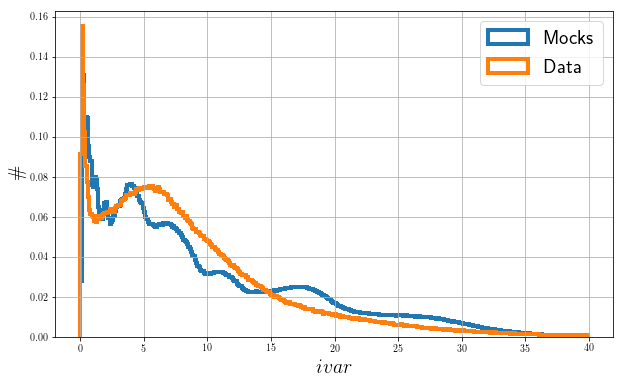

In [491]:
for name,vals in toPlot.items():
    plt.hist(vals['IVAR'],bins=sp.arange(0.,40.,0.1),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$ivar$')
plt.ylabel(r'$\#$')
plt.legend()
plt.grid()
plt.show()

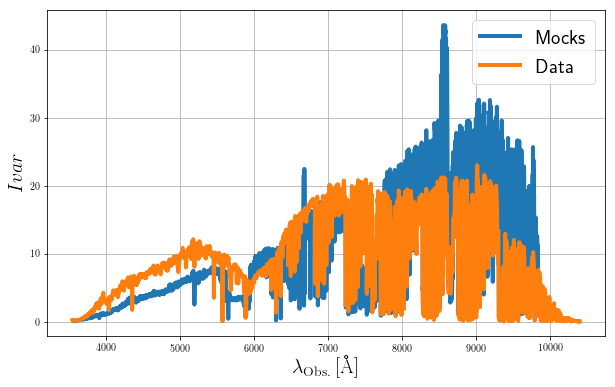

In [492]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in toPlot.items():

    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=vals['IVAR'],minlength=x.size)
    var = sp.bincount(bins,weights=vals['IVAR']**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$Ivar$')
plt.legend()
plt.grid()
plt.show()

### Distribution of SNR = flux * sp.sqrt(ivar)

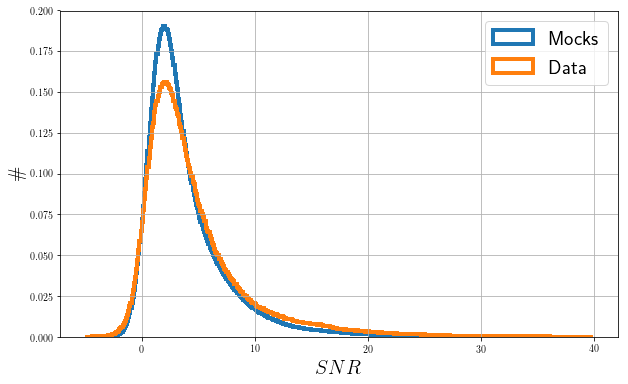

In [493]:
for name,vals in toPlot.items():
    snr = vals['FLUX']*sp.sqrt(vals['IVAR'])
    plt.hist(snr,bins=sp.arange(-5.,40.,0.1),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$SNR$')
plt.ylabel(r'$\#$')
plt.legend()
plt.grid()
plt.show()

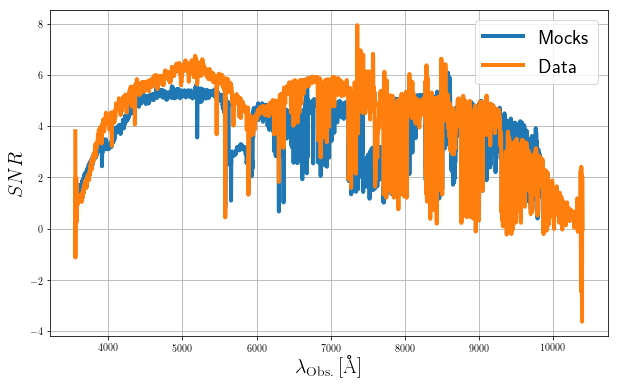

In [494]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in toPlot.items():
    snr = vals['FLUX']*sp.sqrt(vals['IVAR'])
    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=snr,minlength=x.size)
    var = sp.bincount(bins,weights=snr**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$SNR$')
plt.legend()
plt.grid()
plt.show()

# __The delta field__

In [495]:
### List of all the delta attributes functions to plot
all_delta_attributes = {'Mock':mock['picca_delta_attributes'], 'Data':data['picca_delta_attributes']}

### Flux stack vs. observed wavelength

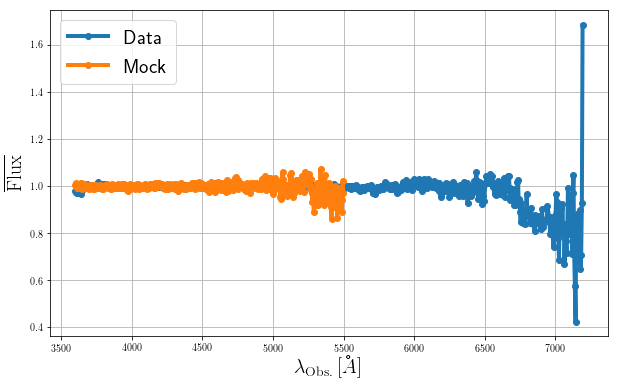

In [496]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[1]['LOGLAM'][:]
    stack  = h[1]['STACK'][:]
    w = h[1]['WEIGHT'][:]>0.
    loglam = loglam[w]
    stack  = stack[w]
    plt.plot(10.**loglam, stack, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')
plt.legend()
plt.grid()

### Mean continuum

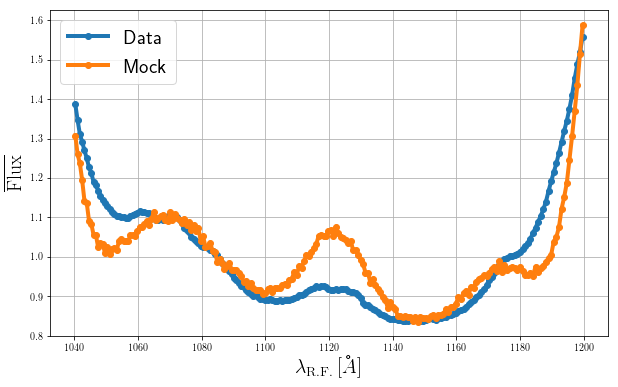

In [497]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam_rest = h[3]['LOGLAM_REST'][:]
    mean_cont = h[3]['MEAN_CONT'][:]
    w = h[3]['WEIGHT'][:]>0.
    loglam_rest = loglam_rest[w]
    mean_cont = mean_cont[w]
    plt.plot(10.**loglam_rest, mean_cont, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\AA]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')
plt.legend()
plt.grid()

### Correction to the pipeline variance

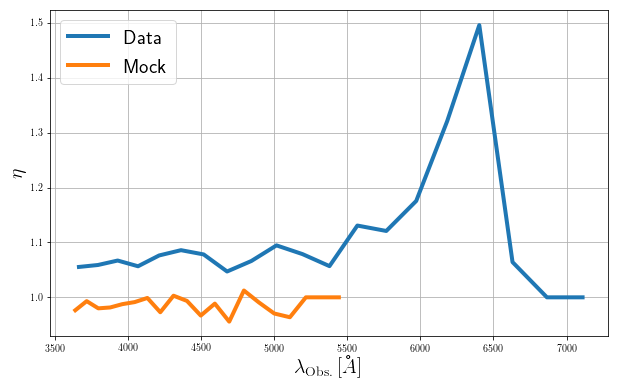

In [498]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    eta = h[2]['ETA'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    eta = eta[w]
    plt.errorbar(10.**loglam, eta, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
plt.ylabel(r'$\eta$')
plt.legend()
plt.grid()

### Large Scale Structure variance

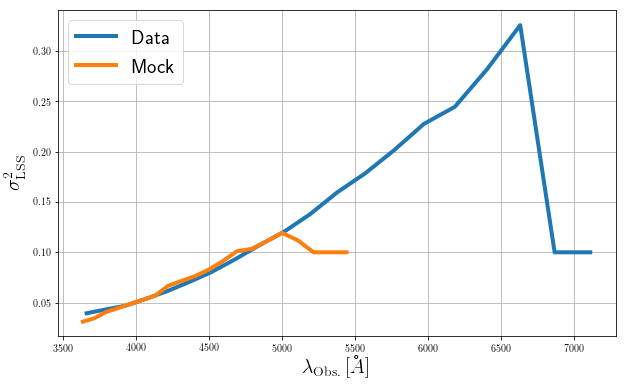

In [499]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    var_lss = h[2]['VAR_LSS'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    var_lss = var_lss[w]
    plt.errorbar(10.**loglam, var_lss, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
plt.ylabel(r'$\sigma^{2}_{\mathrm{LSS}}$')
plt.legend()
plt.grid()

### Let's look at the contribution of the variation of the continuum

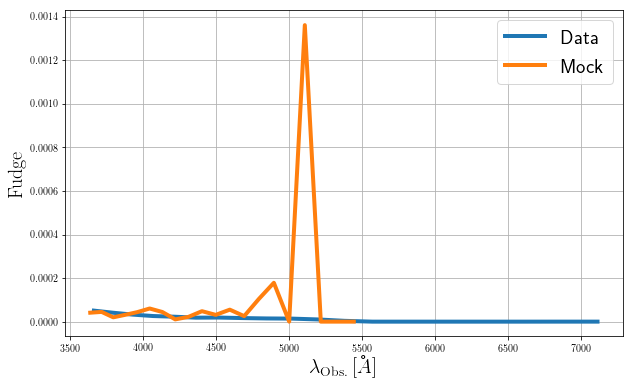

In [500]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    fudge = h[2]['FUDGE'][:]
    w = h[2]['NB_PIXELS'][:]>0
    loglam = loglam[w]
    fudge = fudge[w]
    plt.errorbar(10.**loglam, fudge, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
plt.ylabel(r'$\mathrm{Fudge}$')
plt.legend()
plt.grid()

### 1D Correlation

In [504]:
### List of all the correlation to plot
all_cf1d = {'Mock':mock['picca_cf1d'], 'Data':data['picca_cf1d']}

### The variance of delta in the forest

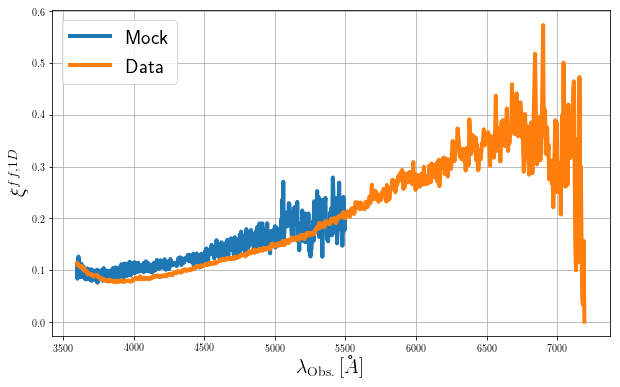

In [505]:
### The variance
for name,path in all_cf1d.items():
    try:
        h = fitsio.FITS(path)
    except:
        print('Couldnt find file {}, skipping'.format(path))
        continue
    head = h[1].read_header() #- in the future replace '1' by '1DCOR'
    llmin = head['LLMIN']
    llmax = head['LLMAX']
    dll = head['DLL']
    n1d = int((llmax-llmin)/dll+1)
    x = sp.arange(0.,n1d)*dll+llmin
    y = h[1]['v1d'][:]
    w = h[1]['wv1d'][:]>0.
    x = x[w]
    y = y[w]
    plt.plot(10.**x,y,linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA] $')
plt.ylabel(r'$\xi^{ff,1D}$')
plt.legend()
plt.grid()

### The normalized correlation in the forest

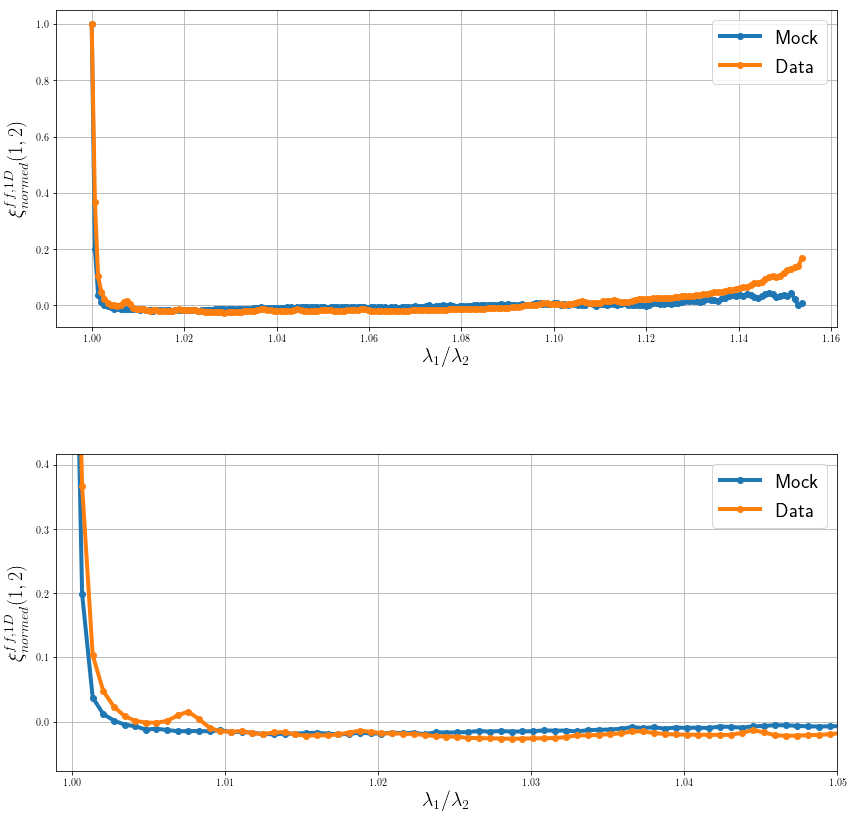

In [506]:
### The normalized correlation
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

### all
for name,path in all_cf1d.items():
    try:
        h = fitsio.FITS(path)
    except:
        print('cant find {}, skipping'.format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ax1.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax1.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax1.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax1.legend()
ax1.grid()

### zoom
ymin = 1.e6
ymax = -1.e6
for name,path in all_cf1d.items():
    try:
        h = fitsio.FITS(path)
    except:
        print("Can't find file {}, skipping".format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ymin = min(ymin,y.min())
    ymax = max(ymax,y[y!=1.].max())
    ax2.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax2.set_xlim([0.999,1.05])
ax2.set_ylim([ymin-0.05,ymax+0.05])
ax2.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax2.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax2.legend()
ax2.grid()

plt.subplots_adjust(hspace=0.4)

# __Fit results__

The cell below will print out a table with the fit parameters for the auto results.
If you want the cross results instead change the first line to

    fi = sorted(glob.glob("xcf*.h5"))

In [510]:
fi = sorted(glob.glob(mock['picca']+'/cf_z_*.h5'))
ff = h5py.File(fi[0],'r')
cosmo_pars = ["bias_LYA","beta_LYA","bias_QSO","beta_QSO","ap","at"]
all_pars = [p.decode('utf-8') for p in ff['best fit'].attrs['list of free pars']]
bname0 = fi[0].replace(".h5","")
ff.close()

print("{:20}".format(""),end="")
for f in fi:
    print("{:^20}".format(f.replace(mock['picca'],'').replace("-exp.h5","")),end="")
print("")

print("{:20}".format("zeff"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        zeff = ff['best fit'].attrs['zeff']
    except:
        print("PROBLEM: {}".format(f))
        continue
    out = "{}".format(round(zeff,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

for par in cosmo_pars:
    print("{:20}".format(par),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        if par in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[par]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
    
for par in all_pars:
    if par in cosmo_pars:
        continue
    print("{:20}".format(par[:20]),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        bname = f.replace(".h5","")
        pa = par.replace(bname0,bname)
        if pa in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[pa]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
print("{:20}".format("chi2/(ndata-npar)"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    chi2 = ff['best fit'].attrs['fval']
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    out = "{}/({}-{})".format(round(chi2,1),ndata,npar)
    print("{:^20}".format(out),end="")
    ff.close()
print("")
print("{:20}".format("probability"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    chi2 = ff['best fit'].attrs['fval']
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    proba = 1.-sp.stats.chi2.cdf(chi2,ndata-npar)
    out = "{}".format(round(proba,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

                         cf_z_0_2.2         cf_z_2.2_2.4        cf_z_2.4_2.6        cf_z_2.6_2.8        cf_z_2.8_3.0        cf_z_3.0_3.2        cf_z_3.2_10     
zeff                        2.31                2.31                2.31                2.31                2.31                2.31                2.31        
bias_LYA              -0.299 +/- 0.034    -0.09 +/- 0.028     -0.163 +/- 0.03     -0.24 +/- 0.046     -0.228 +/- 0.058    -0.051 +/- 0.031    -0.327 +/- 0.081  
beta_LYA            18385.648 +/- 926240.406   0.662 +/- 0.27     1.533 +/- 0.541     3.586 +/- 2.319     3.405 +/- 2.832     0.209 +/- 0.141     3.871 +/- 3.358   
bias_QSO            
beta_QSO            
ap                    0.987 +/- 0.199     1.165 +/- 0.227     0.824 +/- 0.213      0.843 +/- 0.11      1.5 +/- 0.185       0.5 +/- 0.169       0.695 +/- 0.13   
at                     0.75 +/- 0.31       0.632 +/- 0.1      1.166 +/- 0.322     0.813 +/- 0.171     0.505 +/- 0.996      0.88 +/- 0.114     0.661 +

# Wedge plots

The cells below display wedge plots for a given file.

Change the value of `base` to the file you wish to display.

In [567]:
base = 'cf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
toPlot['Data'] = { 'CORR':data['picca_cf'], 'FIT':data['picca_fit_cf'], 'NAME': 'LYA(LYA)xLYA(LYA)'}

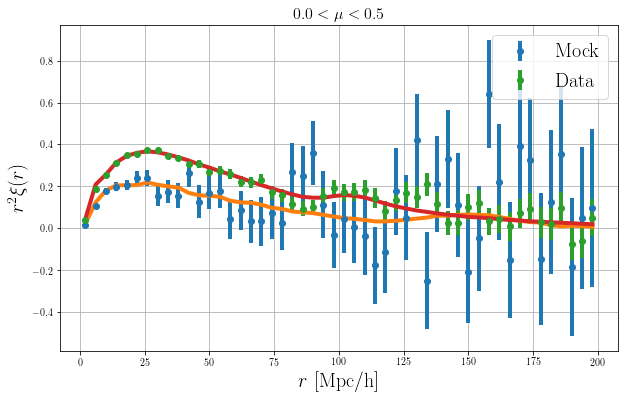

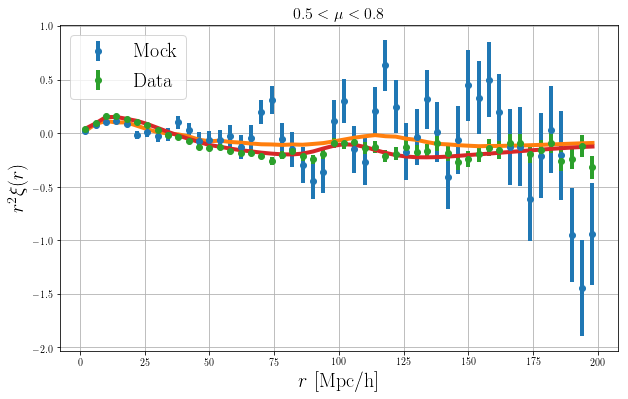

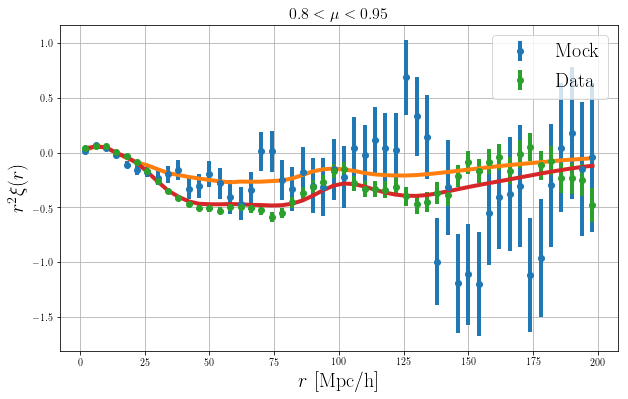

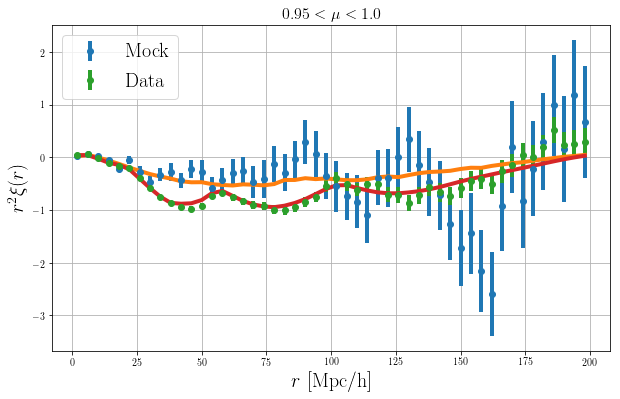

In [568]:
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in toPlot.items():
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(r,f*r**2)
    plt.ylabel(r"$r^2\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

In [570]:
base = 'xcf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
toPlot['Data'] = { 'CORR':data['picca_xcf'], 'FIT':data['picca_fit_xcf'], 'NAME': 'LYA(LYA)xQSO'}

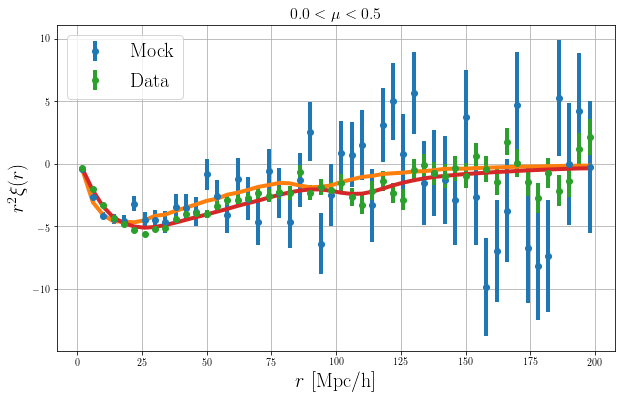

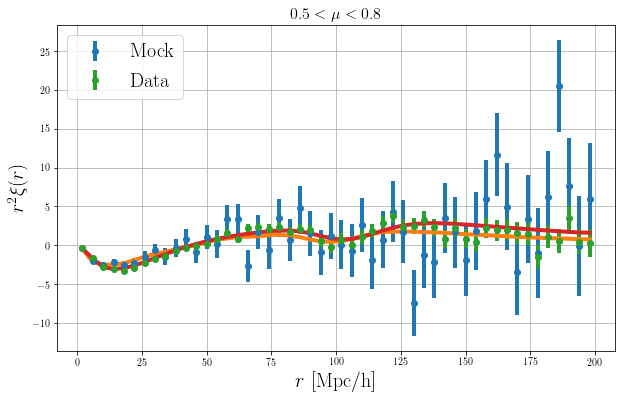

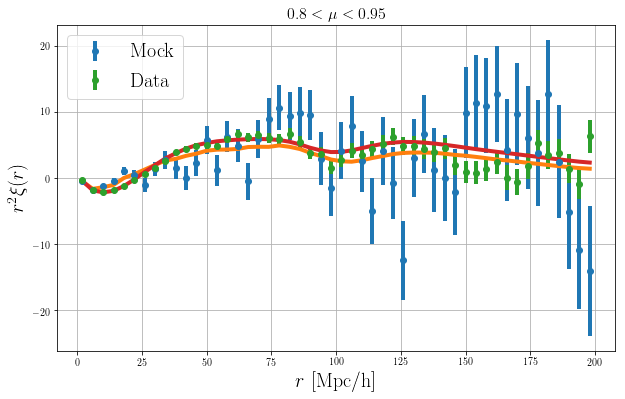

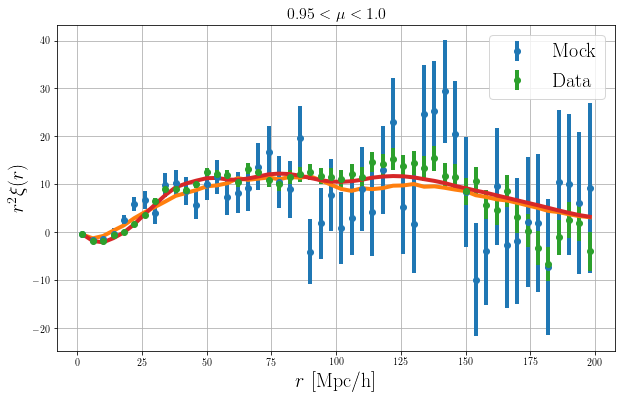

In [571]:
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in toPlot.items():
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(r,f*r**2)
    plt.ylabel(r"$r^2\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

# Slices plots

In [574]:
base = 'xcf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
toPlot['Data'] = { 'CORR':data['picca_xcf'], 'FIT':data['picca_fit_xcf'], 'NAME': 'LYA(LYA)xQSO'}

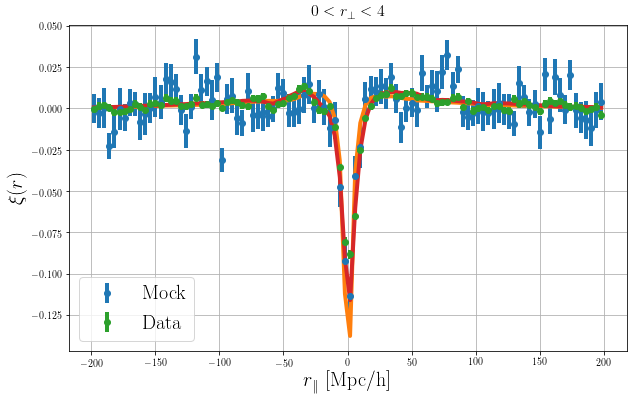

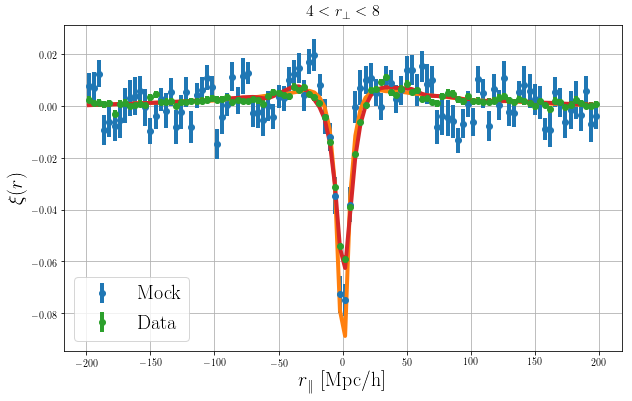

In [575]:
slices = [0, 1]
for s in slices:
    for name,paths in toPlot.items():
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

# The covariance matrices

Let's compare the covariance matrices of the data and of the mocks

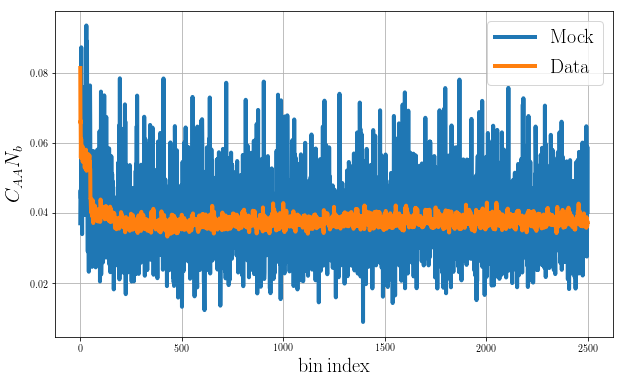

In [576]:
### The auto-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/cf_z_0_10-exp.fits'}
toPlot['Data'] = { 'CORR':data['picca_cf']}
for name,paths in toPlot.items():
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    co = sp.diag(h[1]['CO'][:])
    plt.plot(nb*co,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$C_{AA} N_{b}$")
plt.legend()
plt.grid()
plt.show()

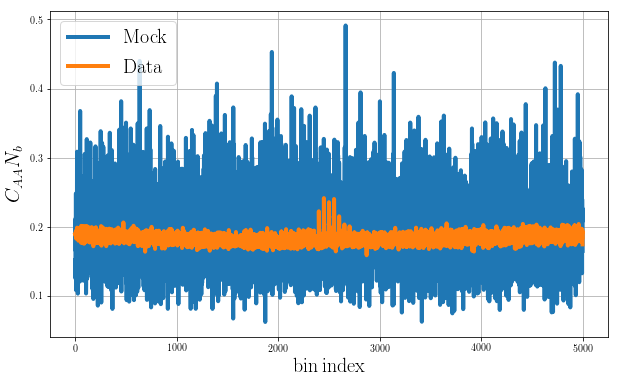

In [577]:
### The cross-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/xcf_z_0_10-exp.fits'}
toPlot['Data'] = { 'CORR':data['picca_xcf']}
for name,paths in toPlot.items():
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    co = sp.diag(h[1]['CO'][:])
    plt.plot(nb*co,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$C_{AA} N_{b}$")
plt.legend()
plt.grid()

# The correlation matrix

Let's look at the difference between the data and the mocks on the correlation matrix

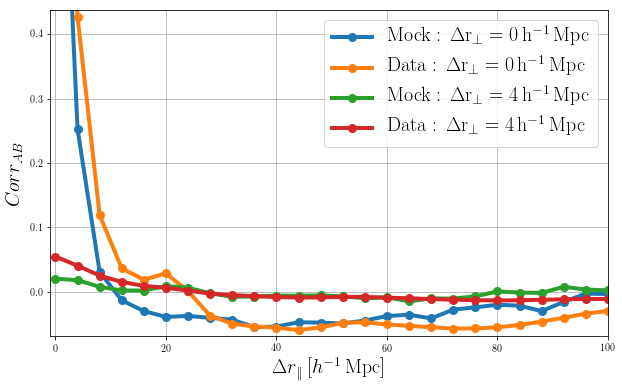

In [562]:
### The auto-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/cf_z_0_10-exp.fits'}
toPlot['Data'] = { 'CORR':data['picca_cf']}

### Load
corr = {}
for name,paths in toPlot.items():
    corr[name] = {}
    h = fitsio.FITS(paths['CORR'])
    corr[name]['CO'] = h[1]['CO'][:]
    tvar = sp.diag(corr[name]['CO'])
    corr[name]['NBBIN'] = tvar.size
    corr[name]['NT'] = h[1].read_header()['NT']
    corr[name]['BINSIZE'] = h[1].read_header()['RTMAX']/h[1].read_header()['NT']
    tcor = corr[name]['CO']/sp.sqrt(tvar*tvar[:,None])
    corr[name]['COR'] = tcor.copy()
    h.close()

### Plot
ymin = 1.
ymax = -1.
for j in range(2):
    for name,tc in corr.items():
        c = tc['COR'].copy()
        a = sp.array( [ sp.mean(sp.diagonal(c, offset=(tc['NT']*i+j))) for i in range(tc['NBBIN']//tc['NT']) ])
        label = '\mathrm{'+name+': \, \Delta r_{\perp} = '+str(int(tc['BINSIZE']*j))+'\,h^{-1}\, \mathrm{Mpc}}'
        plt.plot(tc['BINSIZE']*sp.arange(tc['NBBIN']//tc['NT']),a,linewidth=4,marker='o',markersize=8, label=r'$'+label+'$')
        ymin = min(ymin,a.min())
        ymax = max(ymax,a[a!=1.].max())
plt.xlabel(r'$\Delta r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$')
plt.ylabel(r'$Corr_{AB}$')
plt.xlim([-1.,100.])
plt.ylim([ymin-0.01,ymax+0.01])
plt.legend()
plt.grid()
plt.show()

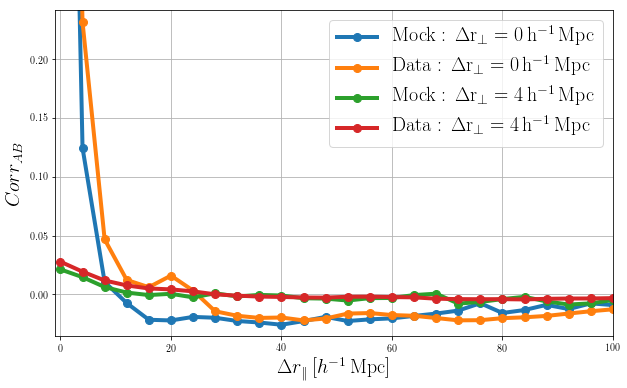

In [563]:
### The cross-correlation
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/xcf_z_0_10-exp.fits'}
toPlot['Data'] = { 'CORR':data['picca_xcf']}

### Load
corr = {}
for name,paths in toPlot.items():
    corr[name] = {}
    h = fitsio.FITS(paths['CORR'])
    corr[name]['CO'] = h[1]['CO'][:]
    tvar = sp.diag(corr[name]['CO'])
    corr[name]['NBBIN'] = tvar.size
    corr[name]['NT'] = h[1].read_header()['NT']
    corr[name]['BINSIZE'] = h[1].read_header()['RTMAX']/h[1].read_header()['NT']
    tcor = corr[name]['CO']/sp.sqrt(tvar*tvar[:,None])
    corr[name]['COR'] = tcor.copy()
    h.close()

### Plot
ymin = 1.
ymax = -1.
for j in range(2):
    for name,tc in corr.items():
        c = tc['COR'].copy()
        a = sp.array( [ sp.mean(sp.diagonal(c, offset=(tc['NT']*i+j))) for i in range(tc['NBBIN']//tc['NT']) ])
        label = '\mathrm{'+name+': \, \Delta r_{\perp} = '+str(int(tc['BINSIZE']*j))+'\,h^{-1}\, \mathrm{Mpc}}'
        plt.plot(tc['BINSIZE']*sp.arange(tc['NBBIN']//tc['NT']),a,linewidth=4,marker='o',markersize=8, label=r'$'+label+'$')
        ymin = min(ymin,a.min())
        ymax = max(ymax,a[a!=1.].max())
plt.xlabel(r'$\Delta r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$')
plt.ylabel(r'$Corr_{AB}$')
plt.xlim([-1.,100.])
plt.ylim([ymin-0.01,ymax+0.01])
plt.legend()
plt.grid()
plt.show()

## __Compare fit results to data or theory__

Redshift bins

In [645]:
#zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10']
zint = ['0:10']

Get the effective redshift of each correlation

In [643]:
weTot = 0.
zeffTot = 0.
    
for cor in ['cf','xcf']:
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        corr = mock['picca']+'/{}_z_{}_{}.fits'.format(cor,zmin,zmax)

        h = fitsio.FITS(corr)
        we = h['COR']['WE'][:]
        we = we.sum(axis=0)
        z = h['ATTRI']['Z'][:]
        rp = h['ATTRI']['RP'][:]
        rt = h['ATTRI']['RT'][:]
        r = sp.sqrt(rp**2. + rt**2.)
        w = (r>80.) & (r<120.)

        zeff = sp.sum( z[w]*we[w] )/sp.sum( we[w] )
        zeffTot = zeffTot*weTot + sp.sum( z[w]*we[w] )
        weTot += sp.sum( we[w] )
        zeffTot /= weTot

        h.close()
        print(corr, zeff)

print('Tot', zeffTot)

/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_0_2.2.fits 2.068542666706438
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_2.2_2.4.fits 2.139801505348335
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_2.4_2.6.fits 2.2721438205055526
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_2.6_2.8.fits 2.448186967483846
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_2.8_3.0.fits 2.619520316608889
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_3.0_3.2.fits 2.795929533348078
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//cf_z_3.2_10.fits 3.036927696714771
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//xcf_z_0_2.2.fits 2.0542237703377273
/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.0/eboss-0.0//xcf_z_2.2_2.4.fits 2.1917011475392303
/project/p

Fit to plots

In [646]:
toPlot = {}

### Mocks Individuals
#lst = ['cf','xcf']

### Mocks Combined
lst = ['cfxcf']

for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in lst:
        toPlot['Mock-{}-z-{}-{}'.format(cor,zmin,zmax)] = {
            'CORR':mock['picca']+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
            'FIT':mock['picca']+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
            'NAME':'{}_z_{}_{}'.format(cor,zmin,zmax),
            'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

In [647]:
### Data Combined
cor = 'cfxcf'
zmin = 0
zmax = 10
toPlot['Data-{}-z-{}-{}'.format(cor,zmin,zmax)] = {'FIT':data['picca_fit_cfxcf']}

Load the fit results

In [648]:
for name,paths in sorted(toPlot.items()):
    if not os.path.isfile(os.path.expandvars(paths['FIT'])):
        print(' WARNING: does not exist ', paths['FIT'])
        continue
    f = h5py.File(os.path.expandvars(paths['FIT']),'r')
    toPlot[name]['FIT_RES'] = {}
    toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
    for k in list(f['best fit'].attrs['list of free pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in list(f['best fit'].attrs['list of fixed pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    f.close()

Useful function to get bias and growth rate of structure

In [649]:
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

### The BAO parameters

[2.31]


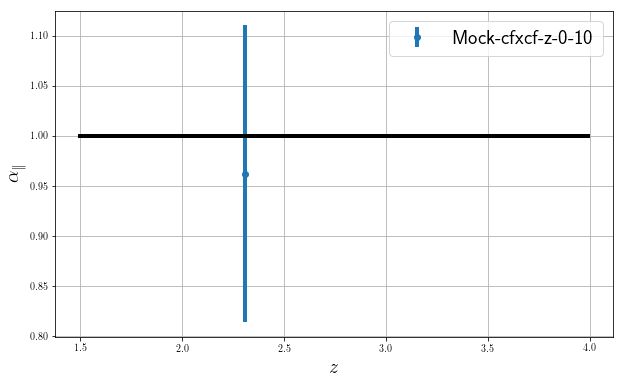

[2.31]


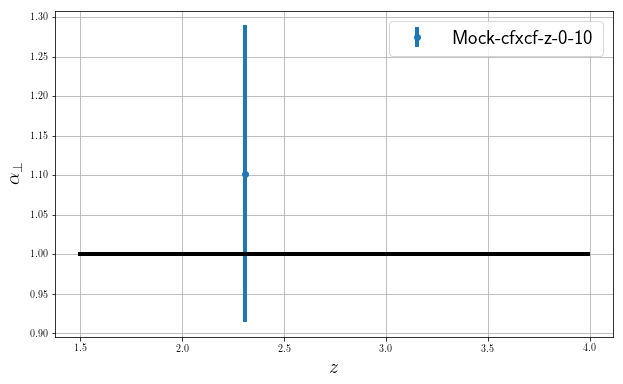

In [650]:
z = sp.arange(1.5,4.,0.01)
latexname = {'ap':'\\alpha_{\parallel}', 'at':'\\alpha_{\perp}'}
for p in ['ap','at']:
    plt.plot(z,sp.ones(z.size),linewidth=4,color='black')
    for name,vals in toPlot.items():
        if 'Data' in name: continue
        lst = [ vals['FIT_RES']  ]
        xxx = sp.array([ el['ZEFF'] for el in lst ])
        print(xxx)
        yyy = sp.array([ el[p][0] for el in lst ])
        zzz = sp.array([ el[p][1] for el in lst ])
        plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)
    plt.xlabel(r'$z$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend()
    plt.grid()
    plt.show()

### The bias of Lya

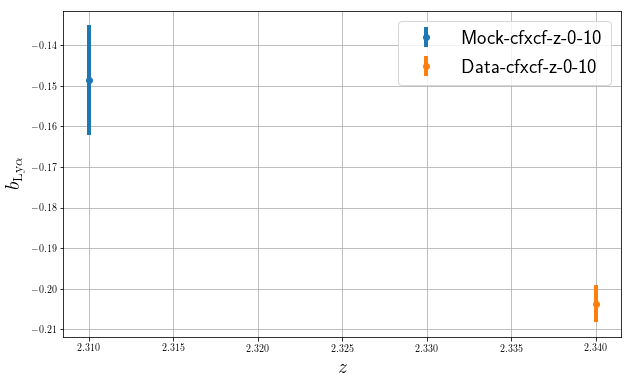

In [651]:
for name,vals in toPlot.items():
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el['bias_LYA'][0] for el in lst ])
    zzz = sp.array([ el['bias_LYA'][1] for el in lst ])
    plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)
plt.xlabel(r'$z$')
plt.ylabel(r'$b_{\mathrm{Ly}\alpha}$')
plt.legend()
plt.grid()
plt.show()

### The beta of Lya

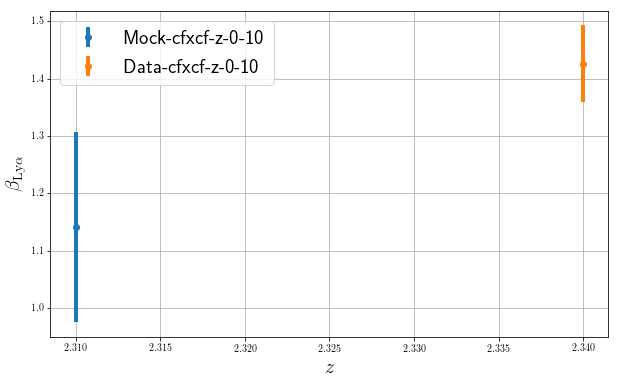

In [652]:
for name,vals in toPlot.items():
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el['beta_LYA'][0] for el in lst ])
    zzz = sp.array([ el['beta_LYA'][1] for el in lst ])
    plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)
plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{\mathrm{Ly}\alpha}$')
plt.legend()
plt.grid()
plt.show()

### The RSD parameter of the QSO

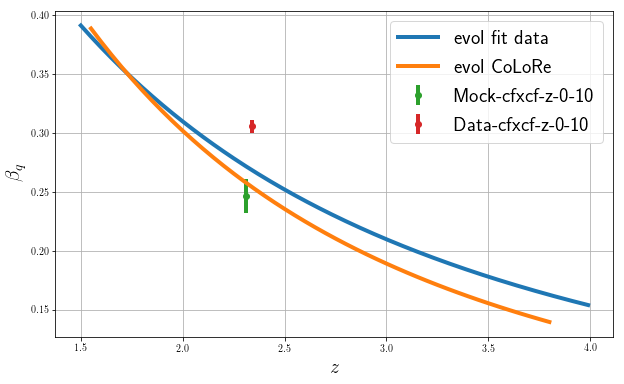

In [653]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4,label='evol fit data')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
w = biasCoLoRe[:,0]>1.5
plt.plot(biasCoLoRe[:,0][w],betaCoLoRe[w],linewidth=4,label='evol CoLoRe')

for name,vals in toPlot.items():
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el['beta_QSO'][0] for el in lst ])
    zzz = sp.array([ el['beta_QSO'][1] for el in lst ])
    plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
plt.grid()
plt.show()